In this notebook, I'll look even deeper into the moving average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import time

from Particledrop import Landing_Flashes

import trackpy

Let's also try to get an animation in the notebook: IT worked! Not sure why it always also plots the last frame, but it does
This function is now calleable for any movie dataset, so movies or backgroundcorrected movies.


In [2]:
def execute_amovie(moviedata):
    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams['figure.dpi'] = 100  
    plt.ioff()
    
    fig = plt.figure()
    axis = plt.axes()
    
    film = plt.imshow(moviedata[0])
    
    def init(): 
        film.set_data(moviedata[0])
        return [film]
    
    def animate(i):
        film.set_array(moviedata[i])
        return [film]
    
    anim = FuncAnimation(fig, animate, frames = moviedata.shape[0], init_func = init, interval = 20, blit = True)

    return anim



In [3]:
nf = 100
fov=[200,300]
meas = Landing_Flashes(fov=fov, seed=5045, numpar = 50, noise = 0, nframes = nf, signal = 20, sizevar=0.2, dark = 5, psize = 4, unevenIllumination = False)
testframe = nf-1
meas.noise = 0
plis = meas.parlist
movie = meas.genStack()
print(np.shape(plis))

execute_amovie(movie)

(50, 3)


With these settings, trackpy finds the particles pretty good, but doesn't find doubles. Let's see if a moving average can change that.




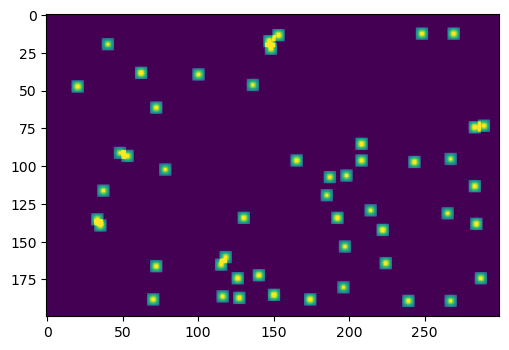

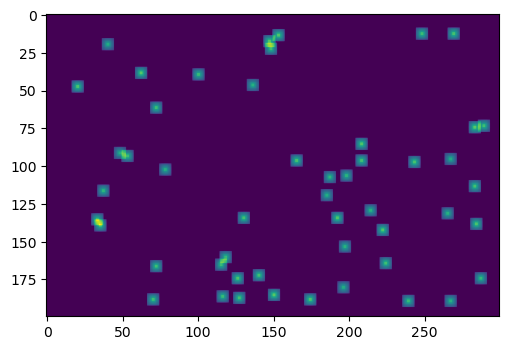

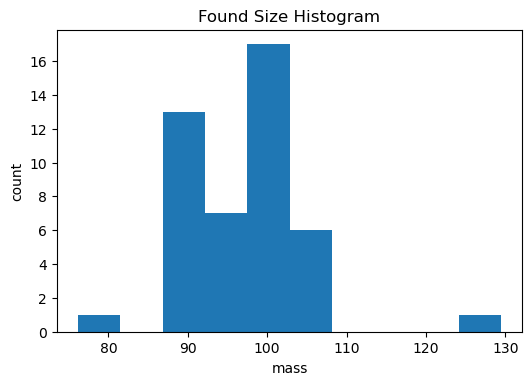

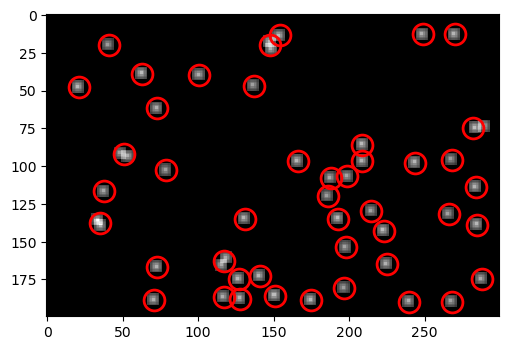

45


In [4]:
plt.figure()
plt.imshow(movie[testframe])

f = trackpy.locate(movie[testframe], 7, minmass = 10, invert = False)

fig, ax = plt.subplots()
plt.title('Found Size Histogram')
ax.hist(f['mass'])

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
plt.figure()
trackpy.annotate(f, movie[testframe]);

print(len(f['mass']))


How does trackpy batch work? How do you see how many particles it has found?

In [5]:
f_2 = trackpy.batch(movie[:,:,:], 7, minmass=10, invert=False, processes='auto')
# print(len(f_2['mass'])) #This sums the mass column, not really useful now.

Frame 99: 45 features
2728


Define the moving average back ground correction movie. 

In [6]:
def BGCMovingAverage(movie):
    start = 6
    end = nf

    BGCma = movie[start:end,:,:] - np.mean([movie[start-5:end-5,:,:],
                                          movie[start-4:end-4,:,:],
                                          movie[start-3:end-3,:,:],
                                          movie[start-2:end-2,:,:],
                                          movie[start-1:end-1,:,:]],
                                          axis = 0)
    #Normalization could be important
    BGCma2 = BGCma/movie[0]
    return BGCma2

BGCMA = BGCMovingAverage(movie)
execute_amovie(BGCMA)


Linking should make it so that particles are remembered. It adds a label 'particle' and these are all unique. As you can see, for the movie it still finds less than 50 particles (Still, one lands over the other, trackpy doesn't find it)

Now look at the moving average corrected one:


In [23]:
print(movie.shape)
print(BGCMA.shape)
f_4 = trackpy.batch(BGCMA[:,:,:], 7, minmass=10, invert=False, processes='auto')
f_4.head(48)

t2 = trackpy.link(f_4, 2, memory=2)
print(t2['particle'].nunique())

Frame 90: 1 trajectories present.
48


To give an overview, we compare the regular movie with the moving average BG movie

Start with regular

In [21]:
f_3 = trackpy.batch(movie[:,:,:], 7, minmass=10, invert=False, processes='auto')
f_3

t = trackpy.link(f_3, 2, memory=2)
print(t['particle'].nunique())

Frame 99: 45 trajectories present.
49


Now switch to BG

In [22]:
f_2 = trackpy.batch(BGCMA[:,:,:], 7, minmass=10, invert=False, processes='auto')
f_2

t = trackpy.link(f_2, 2, memory=2)
print(t['particle'].nunique())

Frame 90: 1 trajectories present.
48
